# **Nenadgledano učenje - Klasterizacija ljudi na osnovu filmskih preferenci**
**Studenti**: 
 - Natalija Stamenković, 1258
 - Milica Todorović, 1256

**Tema**: Klasterizacija mladih ljudi na osnovu njihovih filmskih preferenci i demografskih podataka. Korišćeni skup podataka može se naći na linku: https://www.kaggle.com/miroslavsabo/young-people-survey.

### ***Deskriptivna analiza podataka***
#### *Importovanje paketa*

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, Normalizer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram
%matplotlib inline

pd.set_option('display.max_columns', False)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

#### *Učitavanje skupa podataka*
U tabeli se mogu videti vrednosti atributa datog skupa podataka. Može se uočiti da ceo skup podataka ima 150 kolona, koje predstavljaju kombinaciju celobrojnih ocena iz intervala [1, 5] i kategoričkih vrednosti. 

In [2]:
data = pd.read_csv("dataset/responses.csv")
data.head(2)

,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,Punk,"Hiphop, Rap","Reggae, Ska","Swing, Jazz",Rock n roll,Alternative,Latino,"Techno, Trance",Opera,Movies,Horror,Thriller,Comedy,Romantic,Sci-fi,War,Fantasy/Fairy tales,Animated,Documentary,Western,Action,History,Psychology,Politics,Mathematics,Physics,Internet,PC,Economy Management,Biology,Chemistry,Reading,Geography,Foreign languages,Medicine,Law,Cars,Art exhibitions,Religion,"Countryside, outdoors",Dancing,Musical instruments,Writing,Passive sport,Active sport,Gardening,Celebrities,Shopping,Science and technology,Theatre,Fun with friends,Adrenaline sports,Pets,Flying,Storm,Darkness,Heights,Spiders,Snakes,Rats,Ageing,Dangerous dogs,Fear of public speaking,Smoking,Alcohol,Healthy eating,Daily events,Prioritising workload,Writing notes,Workaholism,Thinking ahead,Final judgement,Reliability,Keeping promises,Loss of interest,Friends versus money,Funniness,Fake,Criminal damage,Decision making,Elections,Self-criticism,Judgment calls,Hypochondria,Empathy,Eating to survive,Giving,Compassion to animals,Borrowed stuff,Loneliness,Cheating in school,Health,Changing the past,God,Dreams,Charity,Number of friends,Punctuality,Lying,Waiting,New environment,Mood swings,Appearence and gestures,Socializing,Achievements,Responding to a serious letter,Children,Assertiveness,Getting angry,Knowing the right people,Public speaking,Unpopularity,Life struggles,Happiness in life,Energy levels,Small - big dogs,Personality,Finding lost valuables,Getting up,Interests or hobbies,Parents' advice,Questionnaires or polls,Internet usage,Finances,Shopping centres,Branded clothing,Entertainment spending,Spending on looks,Spending on gadgets,Spending on healthy eating,Age,Height,Weight,Number of siblings,Gender,Left - right handed,Education,Only child,Village - town,House - block of flats
0,5.00000,3.00000,2.00000,1.00000,2.00000,2.00000,1.00000,5.00000,5.00000,1.00000,1.00000,1.00000,1.00000,1.00000,3.00000,1.00000,1.00000,1.00000,1.00000,5.00000,4.00000,2.00000,5.00000,4.00000,4.00000,1.00000,5.00000,5.00000,3.00000,1.00000,2.00000,1.00000,5.00000,1.00000,3.00000,3.00000,5.00000,3.00000,5.00000,3.00000,3.00000,3.00000,3.00000,5.00000,3.00000,1.00000,1.00000,1.00000,1.00000,5.00000,3.00000,3.00000,2.00000,1.00000,5.00000,5.00000,1.00000,4.00000,4.00000,2.00000,5.00000,4.00000,4.00000,1.00000,1.00000,1.00000,1.00000,1.00000,5,3.00000,1.00000,3.00000,2.00000,never smoked,drink a lot,4.00000,2.00000,2.00000,5.00000,4.00000,2.00000,5.00000,4.00000,4.00000,1.00000,3.00000,5.00000,1.00000,1.00000,3.00000,4.00000,1.00000,3.00000,1.00000,3.00000,1,4.00000,5.00000,4.00000,3.00000,2.00000,1.00000,1.00000,1.00000,4,2.00000,3,i am always on time,never,3.00000,4.00000,3.00000,4.00000,3.00000,4.00000,3.00000,5.00000,1.00000,1.00000,3.00000,5.00000,5.00000,1.00000,4.00000,5.00000,1.00000,4.00000,3.00000,2.00000,3.00000,4.00000,3.00000,few hours a day,3.00000,4.00000,5.00000,3.00000,3.00000,1,3.00000,20.00000,163.00000,48.00000,1.00000,female,right handed,college/bachelor degree,no,village,block of flats
1,4.00000,4.00000,2.00000,1.00000,1.00000,1.00000,2.00000,3.00000,5.00000,4.00000,4.00000,1.00000,3.00000,1.00000,4.00000,4.00000,2.00000,1.00000,1.00000,5.00000,2.00000,2.00000,4.00000,3.00000,4.00000,1.00000,3.00000,5.00000,4.00000,1.00000,4.00000,1.00000,3.00000,4.00000,5.00000,2.00000,4.00000,4.00000,5.00000,1.00000,1.00000,4.00000,4.00000,5.00000,1.00000,2.00000,2.00000,2.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,2.00000,3.00000,3.00000,2.00000,4.00000,2.00000,5.00000,1.00000,1.00000,1.00000,2.00000,1.00000,1,1.00000,3.00000,1.00000,4.00000,never smoked,drink a lot,3.00000,3.00000,2.00000,4.00000,5.00000,4.00000,1.00000,4.00000,4.00000,3.00000,4.00000,3.00000,2.00000,1.00000,2.00000,5.00000,4.00000,4.00000,1.00000,2.00000,1,2.00000,4.00000,3.00000,2.00000,4.00000,4.00000,4.00000,1.00000,3,1.00000,3,i am often early,sometimes,3.00000,4.00000,4.

Ova analiza će se ograničiti na korišćenje podataka vezanih za filmove, kao i demografskih podataka, koji su opisani sledećim kolonama.

In [3]:
# select movie columns
movie_columns = ["Movies", "Horror", "Thriller", "Comedy", "Romantic",
                 "Sci-fi", "War", "Fantasy/Fairy tales", "Animated",
                 "Documentary", "Western", "Action", "Age",
                 "Number of siblings", "Gender", "Education",
                 "Only child", "Village - town", "House - block of flats"]

data_movie = data[movie_columns]
data_movie.head(2)

,Movies,Horror,Thriller,Comedy,Romantic,Sci-fi,War,Fantasy/Fairy tales,Animated,Documentary,Western,Action,Age,Number of siblings,Gender,Education,Only child,Village - town,House - block of flats
0,5.00000,4.00000,2.00000,5.00000,4.00000,4.00000,1.00000,5.00000,5.00000,3.00000,1.00000,2.00000,20.00000,1.00000,female,college/bachelor degree,no,village,block of flats
1,5.00000,2.00000,2.00000,4.00000,3.00000,4.00000,1.00000,3.00000,5.00000,4.00000,1.00000,4.00000,19.00000,2.00000,female,college/bachelor degree,no,city,block of flats


#### *Nedefinisane vrednosti*
Vrši se provera da li postoje atributi koji sadrže određene *missing* vrednosti (vrednosti koje fale). Pokazuje se da skup sadrži *missing* vrednosti.

In [4]:
def check_missing_vals(data):
    # check for missing values
    missing_vals = data.isna().sum()
    print("Missing values: \n" + str(missing_vals))
    return missing_vals.sum() != 0

print("Missing values?", check_missing_vals(data_movie))

Missing values: 
Movies                    6
Horror                    2
Thriller                  1
Comedy                    3
Romantic                  3
Sci-fi                    2
War                       2
Fantasy/Fairy tales       3
Animated                  3
Documentary               8
Western                   4
Action                    2
Age                       7
Number of siblings        6
Gender                    6
Education                 1
Only child                2
Village - town            4
House - block of flats    4
dtype: int64
Missing values? True


Kako skup sadrži nedefinisane vrednosti, kako bi se dalje korektno vršila analiza potrebno je iste otkloniti. Nedefinsane numeričke vrednosti zamenjene su medijan vrednostima respektivnih kolona, dok su kategoričke vrednosti zamenjene najučestalijim kategorijama datih kolona.

In [5]:
# cat_start_idx - index from which the categorical data columns start
def impute(data, cat_start_idx):
    num_data = data[data.columns[0:cat_start_idx]]
    im_num = SimpleImputer(missing_values=np.nan, strategy="median", copy=False)
    im_num.fit_transform(num_data)

    cat_data = data[data.columns[cat_start_idx:]]
    im_cat = SimpleImputer(missing_values=np.nan, strategy="most_frequent", copy=False)
    im_cat.fit_transform(cat_data)

    return pd.concat([num_data, cat_data], axis=1)

cat_start_idx = 14
data_movie = impute(data_movie, cat_start_idx=cat_start_idx)
print("Missing values after impute?", check_missing_vals(data_movie))

Missing values: 
Movies                    0
Horror                    0
Thriller                  0
Comedy                    0
Romantic                  0
Sci-fi                    0
War                       0
Fantasy/Fairy tales       0
Animated                  0
Documentary               0
Western                   0
Action                    0
Age                       0
Number of siblings        0
Gender                    0
Education                 0
Only child                0
Village - town            0
House - block of flats    0
dtype: int64
Missing values after impute? False


#### *Deskripcija atributa*
Sledeća tabela prikazuje statističke informacije o atributima (srednju vrednost, standardnu devijaciju, min, max itd.)

In [6]:
print("Describe numerical data:")
data_movie.iloc[:, :cat_start_idx].describe(include='all')

Describe numerical data:


,Movies,Horror,Thriller,Comedy,Romantic,Sci-fi,War,Fantasy/Fairy tales,Animated,Documentary,Western,Action,Age,Number of siblings
count,1010.00000,1010.00000,1010.00000,1010.00000,1010.00000,1010.00000,1010.00000,1010.00000,1010.00000,1010.00000,1010.00000,1010.00000,1010.00000,1010.00000
mean,4.61584,2.79406,3.38416,4.49604,3.49109,3.11287,3.15545,3.75050,3.78911,3.64653,2.12574,3.53762,20.43069,1.29604
std,0.69327,1.40971,1.19751,0.77912,1.20801,1.31060,1.34695,1.18008,1.21768,1.12931,1.13640,1.23505,2.81924,1.01059
min,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,15.00000,0.00000
25%,4.00000,1.00000,3.00000,4.00000,3.00000,2.00000,2.00000,3.00000,3.00000,3.00000,1.00000,3.00000,19.00000,1.00000
50%,5.00000,3.00000,4.00000,5.00000,4.00000,3.00000,3.00000,4.00000,4.00000,4.00000,2.00000,4.00000,20.00000,1.00000
75%,5.00000,4.00000,4.00000,5.00000,5.00000,4.00000,4.00000,5.00000,5.00000,5.00000,3.00000,5.00000,22.00000,2.00000
max,5.00000,5.00000,5.00000,5.00000,5.00000,5.00000,5.00000,5.00000,5.00000,5.00000,5.00000,5.00000,30.00000,10.00000


In [7]:
print("Describe numerical data:")
data_movie.iloc[:, cat_start_idx:].describe(include='all')

Describe numerical data:


,Gender,Education,Only child,Village - town,House - block of flats
count,1010,1010,1010,1010,1010
unique,2,6,2,2,2
top,female,secondary school,no,city,block of flats
freq,599,622,756,711,599


### *Boxplot atributa*
Sledeći grafik prikazuje boxplot dijagram za svaki od numeričkih atributa. Može se uočiti mali broj potencijalnih outlier-a u kolonama *Movies*, *Comedy*, *Age* i *Number of siblings*.

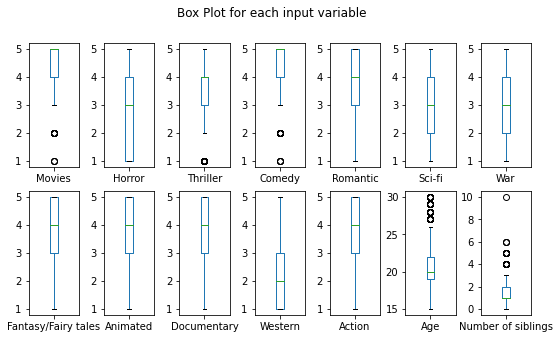

In [8]:
def plot_boxplot(data):
    data.plot(kind='box', figsize=(9, 5), subplots=True, layout=(2, 7),
              sharex=False, sharey=False,
              title='Box Plot for each input variable')
    plt.subplots_adjust(wspace=0.5)

plot_boxplot(data_movie)

#### *Raspodela vrednosti atributa*
Na sledećem dijagramu prikazane su raspodele vrednosti atributa (atributi *Education* i *Age* su prikazani na posebnim graficima). Može se uočiti da određeni filmovi imaju dominatne ocene, ispitanici uglavnom vole komedije, dokumentarce, akcione i romantične filmove, dok se vestern i horor filmovi pokazuju kao nepopularni.

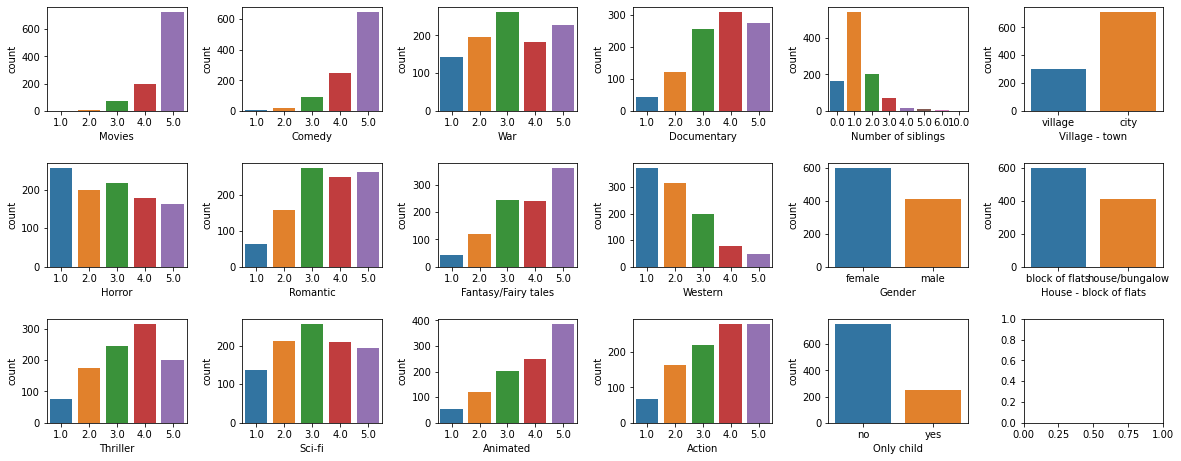

In [9]:
def plot_countplots(data, num_rows, num_cols):
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 7))
    plt.subplots_adjust(hspace=0.5, wspace=.4, top=0.95)

    for i in range(0, num_rows):
        for j in range(0, num_cols):
            index = j * num_rows + i
            if index < data.shape[1]:
                col_name = data.columns[index]
                sns.countplot(x=col_name, data=data, ax=axs[i][j])

plot_countplots(data=data_movie.drop(["Education", "Age"], axis=1), num_rows=3, num_cols=6)

Sledeći dijagrami prikazuju fičere *Education* i *Age*. Pokazuje se da je većina ispitanika u srednjoj školi ili na fakultetu, što se poklapa i sa raspodelom godina ispitanika, s obzirom da većinu čine ljudi između 18-23 godine.

<AxesSubplot:xlabel='Education', ylabel='count'>

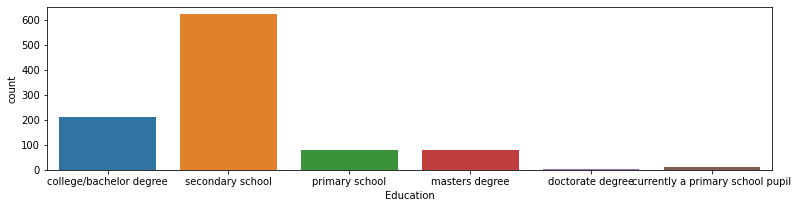

In [10]:
plt.figure(figsize=(13, 3))
sns.countplot(x="Education", data=data_movie)

<AxesSubplot:xlabel='Age', ylabel='count'>

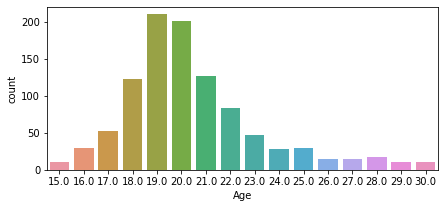

In [11]:
plt.figure(figsize=(7, 3))
sns.countplot(x="Age", data=data_movie)

#### *Enkodiranje labela*
S obzirom da podaci sadrže atribute kategoričkog tipa potrebno je izvršiti enkodiranje datih labela. Kako se radi o atributima čije vrednosti nemaju određenu uređenost, iskorišćen je *one hot encoding*.

In [12]:
def one_hot_encoding(data, cat_start_idx):
    data_cp = data.copy()
    cols = data_cp.columns

    for i in range(cat_start_idx, data_cp.shape[1]):
        df = pd.get_dummies(data=data[cols[i]], prefix=cols[i], drop_first=True)
        data_cp = data_cp.drop(cols[i], axis=1)
        data_cp = pd.concat([data_cp, df], axis=1)

    return data_cp

data_movie_e = one_hot_encoding(data_movie, cat_start_idx)
data_movie_e.head(2)

,Movies,Horror,Thriller,Comedy,Romantic,Sci-fi,War,Fantasy/Fairy tales,Animated,Documentary,Western,Action,Age,Number of siblings,Gender_male,Education_currently a primary school pupil,Education_doctorate degree,Education_masters degree,Education_primary school,Education_secondary school,Only child_yes,Village - town_village,House - block of flats_house/bungalow
0,5.00000,4.00000,2.00000,5.00000,4.00000,4.00000,1.00000,5.00000,5.00000,3.00000,1.00000,2.00000,20.00000,1.00000,0,0,0,0,0,0,0,1,0
1,5.00000,2.00000,2.00000,4.00000,3.00000,4.00000,1.00000,3.00000,5.00000,4.00000,1.00000,4.00000,19.00000,2.00000,0,0,0,0,0,0,0,0,0


#### *Matrica korelacije*
Dijagram prikazuje matricu korelacije fičera. Mogu se uočiti visoki stepeni korelacije između određenih tipova filmova, ali i korelacije tipova filmova sa demografskim podacima. Takođe se može videti da kolone *Number of siblings*, *Only child* i *Village - town* imaju izrazito niske korelacione indekse sa kolonama vezanim za filmove te će biti izbačene iz dalje analize.

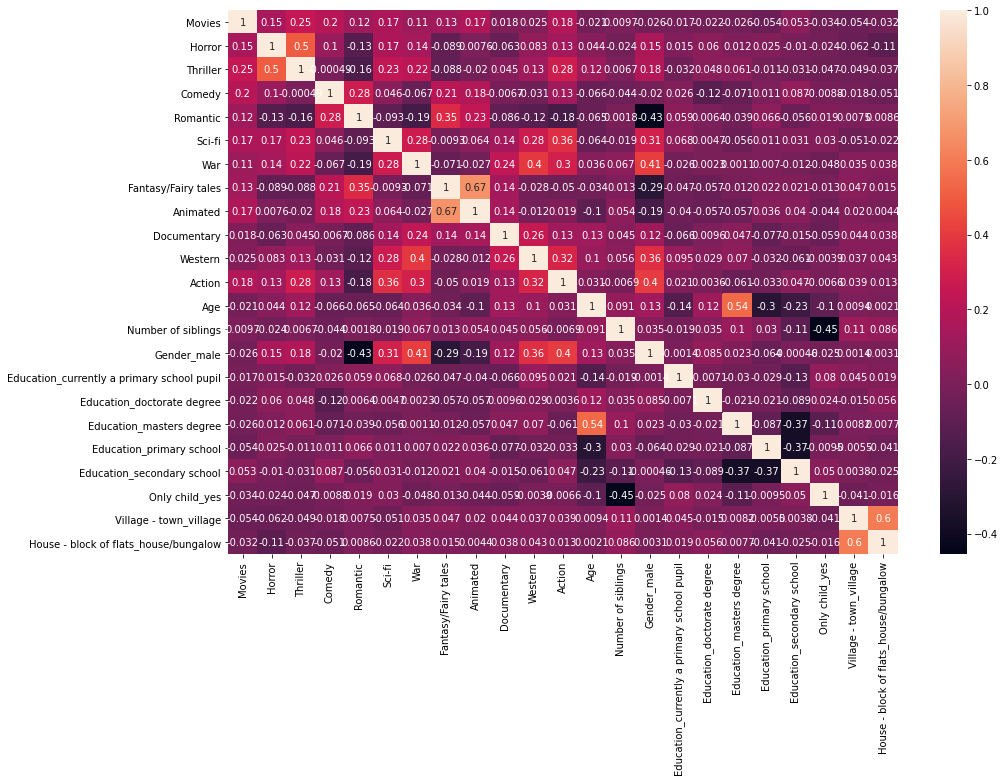

In [13]:
def correlation_matrix(data):
    corr = data.corr()
    fig, ax = plt.subplots(figsize=(15, 10))
    sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, ax=ax)
    
correlation_matrix(data_movie_e)

In [14]:
data_movie_e = data_movie_e.drop(columns=["Number of siblings", "Only child_yes", "Village - town_village"], axis=1)
data_movie = data_movie.drop(columns=["Number of siblings", "Only child", "Village - town"], axis=1)
data_movie_e.head(2)

,Movies,Horror,Thriller,Comedy,Romantic,Sci-fi,War,Fantasy/Fairy tales,Animated,Documentary,Western,Action,Age,Gender_male,Education_currently a primary school pupil,Education_doctorate degree,Education_masters degree,Education_primary school,Education_secondary school,House - block of flats_house/bungalow
0,5.00000,4.00000,2.00000,5.00000,4.00000,4.00000,1.00000,5.00000,5.00000,3.00000,1.00000,2.00000,20.00000,0,0,0,0,0,0,0
1,5.00000,2.00000,2.00000,4.00000,3.00000,4.00000,1.00000,3.00000,5.00000,4.00000,1.00000,4.00000,19.00000,0,0,0,0,0,0,0


### ***Preprocesiranje podataka***
Pored prethodno opisanog enkodiranja labela, preprocesiranje podataka u ovom slučaju podrazumeva i njihovu normalizaciju. Normalizacija efektivno utiče samo na kolone koje se odnose na filmove, s obzirom da se kolone koje se odnose na demografiju zbog enkodiranja labela sastoje samo od binarnih vrednosti.

In [15]:
def normalize(data):
    norm = Normalizer()
    return norm.fit_transform(data)

data_movie_n = normalize(data_movie_e)
# describe the normalized data
pd.DataFrame(data_movie_n).describe(include="all")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,1010.00000,1010.00000,1010.00000,1010.00000,1010.00000,1010.00000,1010.00000,1010.00000,1010.00000,1010.00000,1010.00000,1010.00000,1010.00000,1010.00000,1010.00000,1010.00000,1010.00000,1010.00000,1010.00000,1010.00000
mean,0.19192,0.11540,0.13962,0.18709,0.14545,0.12906,0.13042,0.15566,0.15748,0.15071,0.08750,0.14632,0.84052,0.01657,0.00047,0.00017,0.00282,0.00363,0.02604,0.01696
std,0.03316,0.05772,0.04849,0.03608,0.05232,0.05414,0.05531,0.04982,0.05193,0.04626,0.04568,0.05044,0.04151,0.02018,0.00470,0.00248,0.00962,0.01242,0.02076,0.02066
min,0.04107,0.02955,0.02955,0.03396,0.03054,0.03015,0.03164,0.03101,0.03209,0.03302,0.03186,0.03186,0.69988,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,0.17264,0.05078,0.10228,0.16773,0.11149,0.08623,0.08623,0.12394,0.12460,0.12194,0.04447,0.11297,0.81462,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,0.20080,0.11900,0.14080,0.19514,0.14368,0.13019,0.13043,0.16350,0.16754,0.15680,0.08290,0.15465,0.84081,0.00000,0.00000,0.00000,0.00000,0.00000,0.03973,0.00000
75%,0.21537,0.16344,0.17306,0.21283,0.18628,0.17178,0.17395,0.19807,0.20146,0.18590,0.12048,0.18570,0.86873,0.03994,0.00000,0.00000,0.00000,0.00000,0.04315,0.04109
max,0.26575,0.25582,0.25582,0.26316,0.26316,0.25384,0.25717,0.26279,0.25889,0.25683,0.25126,0.24876,0.94089,0.05143,0.05025,0.03632,0.04564,0.05322,0.05447,0.05447


In [16]:
# feature scaling
def scale_features(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data)

data_movie_s = scale_features(data_movie_e)
# describe the scaled data
pd.DataFrame(data_movie_s).describe(include="all")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,1010.00000,1010.00000,1010.00000,1010.00000,1010.00000,1010.00000,1010.00000,1010.00000,1010.00000,1010.00000,1010.00000,1010.00000,1010.00000,1010.00000,1010.00000,1010.00000,1010.00000,1010.00000,1010.00000,1010.00000
mean,0.00000,0.00000,0.00000,-0.00000,0.00000,-0.00000,-0.00000,0.00000,0.00000,-0.00000,-0.00000,-0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
std,1.00050,1.00050,1.00050,1.00050,1.00050,1.00050,1.00050,1.00050,1.00050,1.00050,1.00050,1.00050,1.00050,1.00050,1.00050,1.00050,1.00050,1.00050,1.00050,1.00050
min,-5.21823,-1.27328,-1.99191,-4.48941,-2.06317,-1.61294,-1.60104,-2.33192,-2.29165,-2.34466,-0.99111,-2.05570,-1.92725,-0.82834,-0.10000,-0.07053,-0.29528,-0.29329,-1.26613,-0.82834
25%,-0.88876,-1.27328,-0.32096,-0.63699,-0.40673,-0.84955,-0.85825,-0.63628,-0.64837,-0.57279,-0.99111,-0.43552,-0.50773,-0.82834,-0.10000,-0.07053,-0.29528,-0.29329,-1.26613,-0.82834
50%,0.55440,0.14616,0.51452,0.64716,0.42149,-0.08616,-0.11546,0.21154,0.17328,0.31315,-0.11070,0.37456,-0.15284,-0.82834,-0.10000,-0.07053,-0.29528,-0.29329,0.78981,-0.82834
75%,0.55440,0.85588,0.51452,0.64716,1.24971,0.67722,0.62732,1.05935,0.99492,1.19909,0.76970,1.18465,0.55692,1.20724,-0.10000,-0.07053,-0.29528,-0.29329,0.78981,1.20724
max,0.55440,1.56560,1.35000,0.64716,1.24971,1.44061,1.37011,1.05935,0.99492,1.19909,2.53052,1.18465,3.39597,1.20724,10.00000,14.17745,3.38661,3.40955,0.78981,1.20724


### ***Selekcija fičera***
Selekcija fičera u okviru ovog problema svodi se na korišćenje PCA (*Principal Compontent Analysis*) algoritma. 

In [17]:
def pca_selection(n_components, data):
    pca = PCA(n_components=n_components, random_state=200, whiten=True)
    data = pca.fit_transform(data)

    var_ratio = pca.explained_variance_ratio_*100
    print("Variance ratio - PCA\n", var_ratio)
    print("Total variance - PCA: ", np.sum(var_ratio))

    return data, var_ratio

def plot_pca(variance):
    plt.figure(figsize=(3, 2))
    plt.plot(variance)
    plt.xlabel('Number of components')
    plt.ylabel("Variance")

Prvo će biti pokrenuta PCA selekcija sa svim fičerima, ne bi li se utvrdio odgovarajući broj principalnih komponenti. Može se zaključiti da zadržavanje 12-13 komponenti zadržava zadovoljavajuću količinu varijanse. Date vrednosti principalnih komponenti je potrebno ponovo normalizovati.

Variance ratio - PCA
 [2.20600176e+01 1.93794049e+01 1.23141551e+01 7.72076818e+00
 6.74686226e+00 5.69227233e+00 5.26679238e+00 4.85081131e+00
 4.14795732e+00 3.03514829e+00 2.46071402e+00 2.15819550e+00
 1.35519840e+00 1.31259288e+00 7.04901782e-01 3.67033131e-01
 1.97597504e-01 1.54632709e-01 5.68022280e-02 1.81421634e-02]
Total variance - PCA:  100.00000000000001


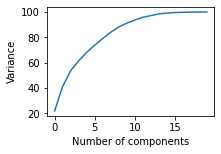

In [18]:
data_pca, var_ratio = pca_selection(data_movie_n.shape[1], data_movie_n)
plot_pca(variance=np.cumsum(var_ratio))

In [19]:
data_pca, var_ratio = pca_selection(n_components=13, data=data_movie_n)
data_pca_n = normalize(data_pca)
data_pca_s = scale_features(data_pca)

Variance ratio - PCA
 [22.06001755 19.3794049  12.31415514  7.72076818  6.74686226  5.69227233
  5.26679238  4.85081131  4.14795732  3.03514829  2.46071402  2.1581955
  1.3551984 ]
Total variance - PCA:  97.18829760215989


### ***Klasterizacija***
U nastavku je data funkcija kojom se vrši inicijalna evaluacija klasterizacije, odnosno određivanje siluet i Calinski-Harabasz skora.

In [20]:
def eval_scores(data, labels, nn_metric):
    print("Silhouette score:", silhouette_score(data, labels, metric=nn_metric))
    print("Calinski Harabasz score:", calinski_harabasz_score(data, labels))

#### *KMeans*
Prva algoritam klasterizacije isproban je KMeans. KMeans zahteva određivanje broja klastera koji će biti koriščeni. Adekvatan broj klastera može se odrediti na osnovu metode lakta (*elbow* metoda). Algoritam je prvo evaluiran na inicijalnim podacima (bez korišćenja selekcije fičera).

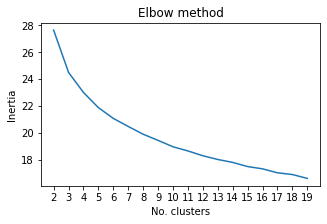

In [21]:
def elbow_method(data, num_iters):
    scores = []
    n_clusters = []
    for i in range(2, num_iters):
        km = KMeans(n_clusters=i, init="k-means++",
                    max_iter=3000, random_state=0)
        km.fit(data)
        scores.append(km.inertia_)
        n_clusters.append(i)
        
    plt.figure(figsize=(5, 3))
    plt.plot(n_clusters, scores)
    plt.xticks(n_clusters)
    plt.title("Elbow method")
    plt.xlabel("No. clusters")
    plt.ylabel("Inertia")
    
elbow_method(data=data_movie_n, num_iters=20)

*Elbow* metoda u ovom slučaju ne daje jasno definisan "lakat", čini se da bi povoljan broj klaster bio između 3-5. Dalji pokušaj određivanja povoljnog broja klastera svodi se na grafički prikaz skora siluete i Calinski-Harabasz skora.

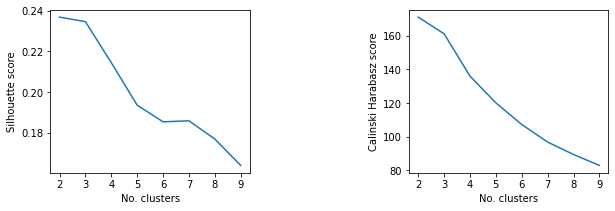

In [22]:
def plot_score(algorithm, data, sil_scores, c_h_scores, nn_metric):
    algorithm.fit(data)
    sil_scores.append(silhouette_score(data, algorithm.labels_, metric=nn_metric))
    c_h_scores.append(calinski_harabasz_score(data, algorithm.labels_))

    return sil_scores, c_h_scores
    
def plot_scores(data, num_iters, algorithm_name, nn_metric):
    sil_scores = []
    c_h_scores = []
    n_clusters = []
    for i in range(2, num_iters):

        if algorithm_name == "kmeans":
            algorithm = KMeans(n_clusters=i, init="k-means++",
                               max_iter=3000, random_state=0)
        elif algorithm_name == "agglomerative":
            algorithm = AgglomerativeClustering(n_clusters=i)

        sil_scores, c_h_scores = plot_score(algorithm, data, sil_scores, c_h_scores, nn_metric)
        n_clusters.append(i)

    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    plt.subplots_adjust(wspace=.8)

    axs[0].plot(n_clusters, sil_scores)
    axs[0].set(xlabel="No. clusters", ylabel="Silhouette score",
               xticks=n_clusters)

    axs[1].plot(n_clusters, c_h_scores)
    axs[1].set(xlabel="No. clusters", ylabel="Calinski Harabasz score",
               xticks=n_clusters)

plot_scores(data=data_movie_n, num_iters=10, algorithm_name="kmeans", nn_metric="cosine")

Prethodni dijagrami navode na zaključak da bi bilo adekvatno vršiti klasterizaciju u **3** klastera.

Algoritam je dalje testiran korišćenjem podataka nakon PCA selekcije fičera.

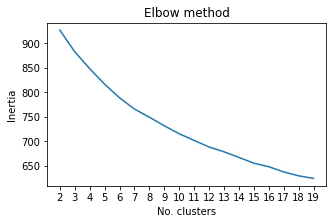

In [23]:
elbow_method(data=data_pca_n, num_iters=20)

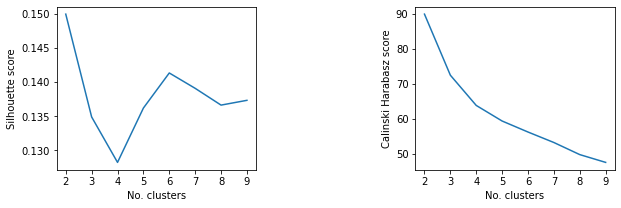

In [24]:
plot_scores(data=data_pca_n, num_iters=10, algorithm_name="kmeans", nn_metric="cosine")

Očigledno je da se KMeans klasterizacija pogoršala pri selekciji fičera te će u daljoj analizi biti korišćeni inicijalni podaci.

#### *DBSCAN*
Naredni testiran algoritam je DBSCAN. Za razliku od KMeans, DBSCAN ne zahteva eksplicitno zadavanje broja klastera. Glavni parametri DBSCAN-a su *epsilon* - maksimalna distanca između dve tačke tako da se tačke mogu smatrati u međusobnoj okolini i minimalni broj tačaka u klasteru. Određivanje odgovarajuće vrednosti *epsilon* parametra može se vršiti korišćenjem nenadgledanog *NearestNeightbors* klasifikatora. Umesto normalizovanih podataka, za ovaj algoritam korišćeni su skalirani podaci.

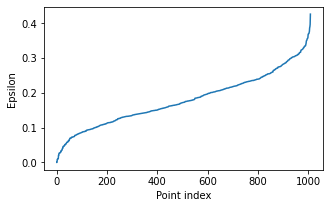

In [25]:
def find_optimal_eps(data, nn_metric):
    neigh = NearestNeighbors(n_neighbors=2, metric=nn_metric)
    nbrs = neigh.fit(data)
    distances, indices = nbrs.kneighbors(data)

    distances = np.sort(distances, axis=0)
    distances = distances[:, 1]
    
    plt.figure(figsize=(5, 3))
    plt.plot(distances)
    plt.xlabel("Point index")
    plt.ylabel("Epsilon")
    
find_optimal_eps(data_movie_s, "cosine")

Prethodni dijagram pokazuje da bi odgovarajuća vrednost bila *epsilon* ~ **0.35**.

In [26]:
dbscan = DBSCAN(eps=0.35, min_samples=40, metric="cosine")
dbscan.fit(data_movie_s)

eval_scores(data_movie_s, dbscan.labels_, "cosine")

Silhouette score: 0.06577194409897984
Calinski Harabasz score: 59.15376679008841


Dobijeni skorovi su drastično gori od skorova dobijenih KMeans klasterizacijom. Pored skorova, može se videti i dobijeni broj klastera i broj tačaka koje predstavljaju šum.

In [27]:
dbscan_clusters_ = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
dbscan_noise_ = list(dbscan.labels_).count(-1)

print(f"Estimated number of clusters: {dbscan_clusters_}")
print(f"Estimated number of noise points: {dbscan_noise_}")

Estimated number of clusters: 4
Estimated number of noise points: 612


Može se primetiti da je više od polovine ukupnih tačaka obeleženo kao šum, što zajedno sa prethodno dobijenim ocena klasterizacije daje izuzetno nepovoljne rezultate pri korišćenju datog algoritma. Zbog generalno loših rezultata datog algoritma nad ovim skupom podataka, DBSCAN se neće razmatrati u daljoj analizi.

#### *Hijerarhijska klasterizacija (Agglomerative Clustering)*
Naredni razmatrani algoritam je Aglomerativna klasterizacija, odnosno hijerarhijska klasterizacija. Slično KMeans klasterizaciji potrebno je odrediti odgovarajući broj klastera, što je vršeno uz pomoć vizuelizacije skorova klasterizacije korišćenjem različih brojeva klastera.

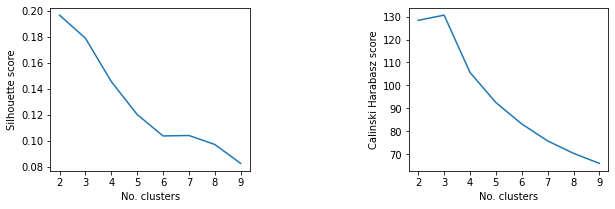

In [28]:
plot_scores(data=data_movie_n, num_iters=10, algorithm_name="agglomerative", nn_metric="cosine")

Slično, prethodni dijagrami navode na zaključak da bi bilo adekvatno vršiti klasterizaciju u **3** klastera.

Dalje, pokušana je redukcija dimenzionalnosti korišćenjem principalnih komponenti dobijenim PCA algoritmom.

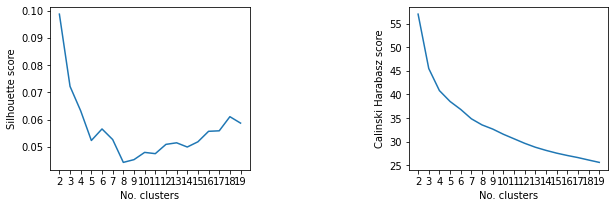

In [29]:
plot_scores(data=data_pca_n, num_iters=20, algorithm_name="agglomerative", nn_metric="cosine")

Skorovi dobijeni pri redukciji dimenzionalnosti su značajno gori od prethodnih rezultata, te će u daljoj analizi biti korišćeni inicijalni podaci.

#### *MeanShift*
Sledeći isproban algoritam klasterizacije je MeanShift, koji slično DBSCAN-u ne zahteva eksplicitno zadavanje broja klastera. Najznačajniji parametar MeanShift algoritma je *bandwidth*, za čiju procenu se može koristi funkcija sklearn biblioteke.

In [65]:
ms_bandwidth = estimate_bandwidth(data_movie_n, quantile=0.1)

In [67]:
ms =  MeanShift(bandwidth=ms_bandwidth, bin_seeding=True)
ms = ms.fit(data_movie_n)


eval_scores(data_movie_n, ms.labels_, nn_metric="cosine")

Silhouette score: 0.313571605854199
Calinski Harabasz score: 17.2172095156344


MeanShift daje do sada najbolji skor siluete, ali izraženo nizak Calinski Harabasz skor.

In [75]:
def print_cluster_elements(labels_unique, label_counts):
    for cluster, num_elements in zip(labels_unique, label_counts):
        print(f"Cluster {cluster}: {num_elements}")
    
ms_labels_unique_, ms_labels_counts_ = np.unique(ms.labels_, return_counts=True)

ms_clusters_ = len(ms_labels_unique_)
print(f"Estimated number of clusters : {ms_clusters_}")
print_cluster_elements(ms_labels_unique_, ms_labels_counts_)

Estimated number of clusters : 2
Cluster 0: 998
Cluster 1: 12


Međutim, dalja analiza pokazuje da su ovim pristupom dobijena samo 2 klastera, pri čemu su skoro sve tačke dodeljene nultom klasteru. Zaključuje se da data tehnika nije pogodna za ovaj skup podataka, te se MeanShift neće razmatrati u daljoj analizi.

**Dosadašnja analiza je pokazala da KMeans i Agglomerative Clustering algoritmi daju približne ocene kvaliteta klastera, pri čemu se KMeans ispostavlja za nijansu bolji, dok DBSCAN i MeanShift daju izraženo lošije rezultate.**

### ***Vizuelizacija klastera***
U ovoj sekciji data su vizuelizacije dobijenih klastera korišćenjem sve tri metode. Funkcije kojim je vršena vizuelizacija date su u nastavku.

In [30]:
def plot_clusters_pca_2d(n_components, data, labels, num_clusters):
    """
    Transform the data using PCA.
    Then plot the clusters using the first 2 components
    """
    pca = PCA(n_components=n_components)
    x_pca = pca.fit_transform(data)

    sns.scatterplot(x=x_pca[:, 0], y=x_pca[:, 1], hue=labels)\
        .set_title(f"PCA: {num_clusters} clusters")


def plot_clusters_pca_3d(n_components, data, labels, num_clusters):
    """
    Transform the data using PCA.
    Then plot the clusters using the first 3 components in 3D
    """
    pca = PCA(n_components=n_components)
    x_pca = pca.fit_transform(data)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(xs=x_pca[:, 0], ys=x_pca[:, 1], zs=x_pca[:, 2], c=labels)

#### *KMeans*
Prethodnom analizom utvrđeno je da će KMeans biti korišćen sa **inicijalnim** podacima i **3** klastera.

In [31]:
km_n_clusters = 3
km = KMeans(n_clusters=km_n_clusters, init="k-means++",
            max_iter=3000, random_state=0)
km.fit(data_movie_n)

# evaluate clusters
eval_scores(data_movie_n, km.labels_, "cosine")

Silhouette score: 0.2345580406267787
Calinski Harabasz score: 161.04938448861668


Na početku data je vizuelizacija klastera u 2D i 3D korišćenjem PCA za svođenje na manje dimenzioni prostor. Obe vizuelizacije pokazuju jasno separatisane klastere.

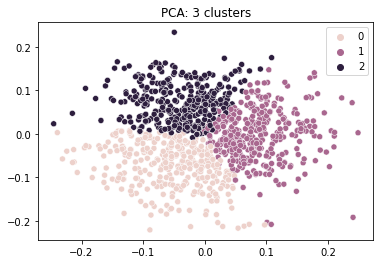

In [32]:
plot_clusters_pca_2d(3, data_movie_n, km.labels_, num_clusters=km_n_clusters)

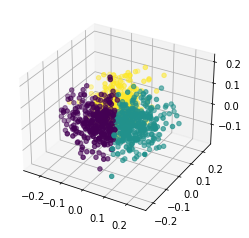

In [33]:
plot_clusters_pca_3d(3, data_movie_n, km.labels_, num_clusters=km_n_clusters)

Dalje je izvršena vizuelizacija pojedinačnih klastera koriščenjem originalnih vrednosti atributa (pre normalizacije/skaliranja), kao i prikaz centara odgovarajućih klastera.

In [34]:
km_clusters = data_movie.groupby(km.labels_)
km_clusters_means = data_movie_e.groupby(km.labels_).mean()
km_clusters_means

,Movies,Horror,Thriller,Comedy,Romantic,Sci-fi,War,Fantasy/Fairy tales,Animated,Documentary,Western,Action,Age,Gender_male,Education_currently a primary school pupil,Education_doctorate degree,Education_masters degree,Education_primary school,Education_secondary school,House - block of flats_house/bungalow
0,4.38365,2.71384,3.43082,4.18868,3.00629,2.73270,3.08176,2.83962,2.76101,3.56604,2.02516,3.38365,22.52830,0.49686,0.00314,0.01572,0.21069,0.01887,0.50943,0.41824
1,4.77374,3.31285,3.92458,4.58659,3.26257,3.98603,4.03073,3.84637,4.04469,3.91061,2.68436,4.22346,19.25698,0.62570,0.01955,0.00000,0.01117,0.12291,0.65922,0.41620
2,4.66766,2.31437,2.76048,4.69162,4.19760,2.53892,2.28743,4.51497,4.49401,3.44012,1.62275,2.94910,19.69162,0.08683,0.00599,0.00000,0.02994,0.08982,0.67066,0.38623


**Klaster 0**

Centar datog klastera prikazan je sledećom tabelom. Distribucija vrednosti atributa u okviru klastera data je na sledećim dijagramima, pri čemu se *Age* i *Education* fičeri izdvojeni zbog bolje preglednosti.

In [35]:
km_clusters_means.iloc[[0]]

,Movies,Horror,Thriller,Comedy,Romantic,Sci-fi,War,Fantasy/Fairy tales,Animated,Documentary,Western,Action,Age,Gender_male,Education_currently a primary school pupil,Education_doctorate degree,Education_masters degree,Education_primary school,Education_secondary school,House - block of flats_house/bungalow
0,4.38365,2.71384,3.43082,4.18868,3.00629,2.73270,3.08176,2.83962,2.76101,3.56604,2.02516,3.38365,22.52830,0.49686,0.00314,0.01572,0.21069,0.01887,0.50943,0.41824


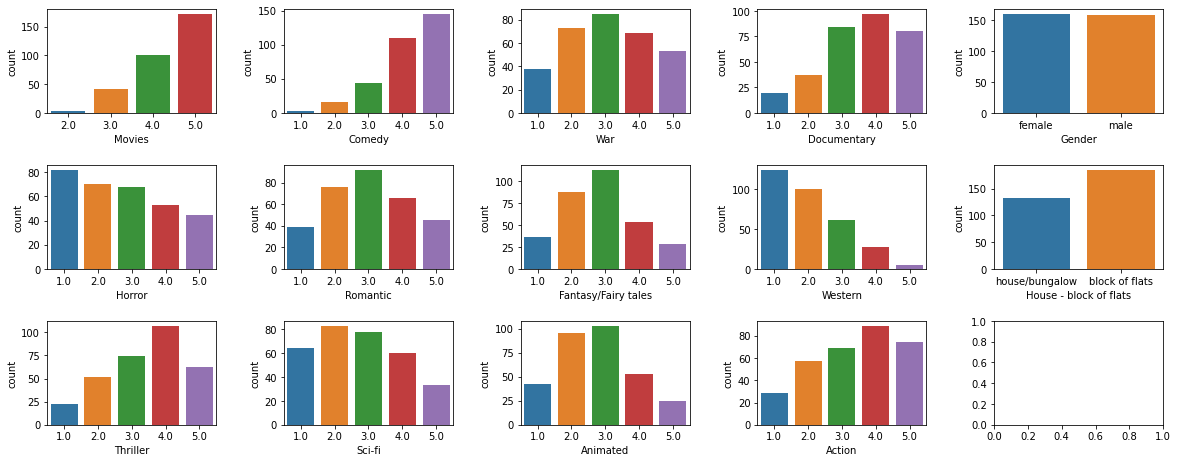

In [36]:
km_0 = km_clusters.get_group(0)
plot_countplots(data=km_0.drop(["Education", "Age"], axis=1),
                num_rows=3, num_cols=5)

<AxesSubplot:xlabel='Education', ylabel='count'>

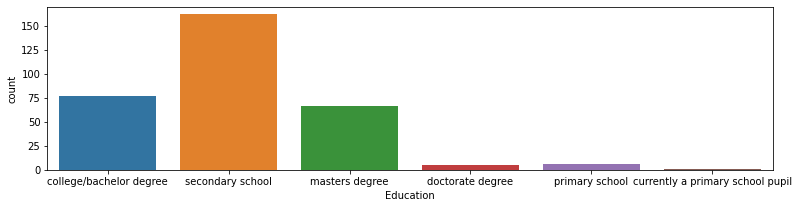

In [37]:
plt.figure(figsize=(13, 3))
sns.countplot(x="Education", data=km_0)

<AxesSubplot:xlabel='Age', ylabel='count'>

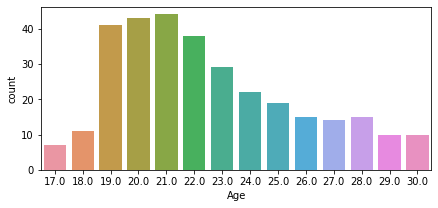

In [38]:
plt.figure(figsize=(7, 3))
sns.countplot(x="Age", data=km_0)

Zastupljenost muškaraca i žena u ovom klasteru je priblizno jednaka, te *Gender* atribut gubi na značaju u analizi nultog klastera. Međutim, može se uočiti da su gotovo svi visoko-obrazovani ljudi (M.S./M.A., PhD i većina B.A./B.S.) svrstani u ovaj klaster. Takođe, starosna struktura ukazuje da je većina ispitanika u rasponu od 19 - 30 godina. Ispitanici u ovom klasteru imaju nisku preferencu za *Horor*, *Sci-fi*, *Fantasy/Fairy tale*, *Animated* i *Western* filmove. *Romantic*, *War* i *Thriller*  filmovi imaju ocenu između 3-3.5, što ih čini prosekom, nisu nužno omiljeni ispitanicima ali se mogu nekada naći na njihovoj "watch" listi. Ispitanici iz ovog klastera vole da gledaju *Thriller* i *Documentary* filmove, pri čemu su *Comedy* filmovi ubedljivo najomiljeniji.

**Klaster 1**

In [39]:
km_clusters_means.iloc[[1]]

,Movies,Horror,Thriller,Comedy,Romantic,Sci-fi,War,Fantasy/Fairy tales,Animated,Documentary,Western,Action,Age,Gender_male,Education_currently a primary school pupil,Education_doctorate degree,Education_masters degree,Education_primary school,Education_secondary school,House - block of flats_house/bungalow
1,4.77374,3.31285,3.92458,4.58659,3.26257,3.98603,4.03073,3.84637,4.04469,3.91061,2.68436,4.22346,19.25698,0.62570,0.01955,0.00000,0.01117,0.12291,0.65922,0.41620


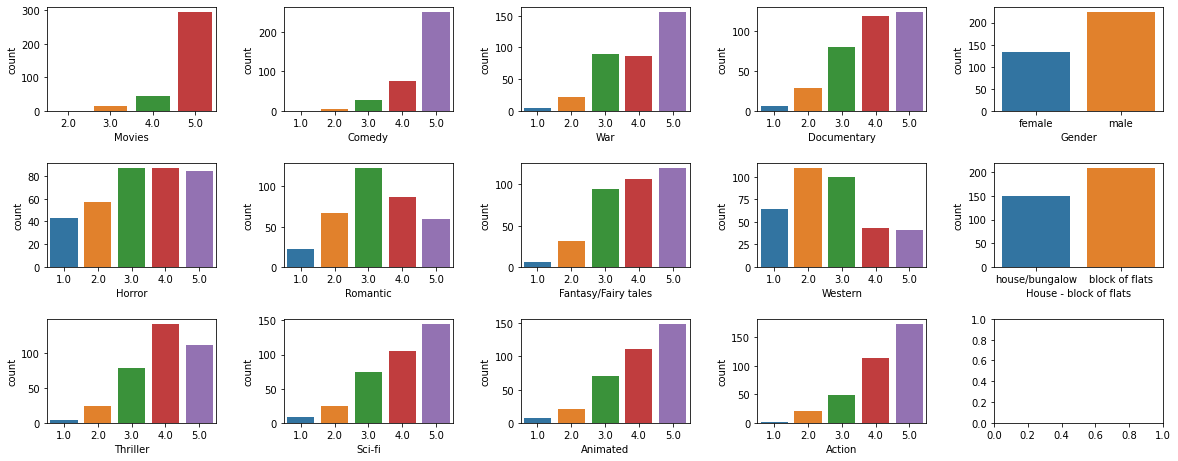

In [40]:
km_1 = km_clusters.get_group(1)
plot_countplots(data=km_1.drop(["Education", "Age"], axis=1),
                num_rows=3, num_cols=5)

<AxesSubplot:xlabel='Education', ylabel='count'>

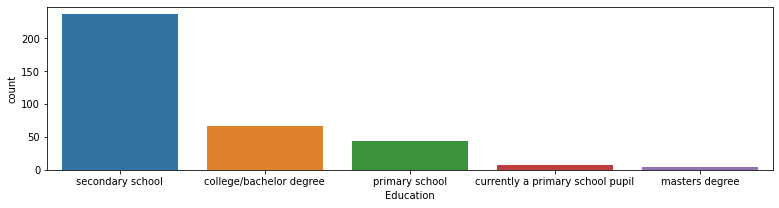

In [41]:
plt.figure(figsize=(13, 3))
sns.countplot(x="Education", data=km_1)

<AxesSubplot:xlabel='Age', ylabel='count'>

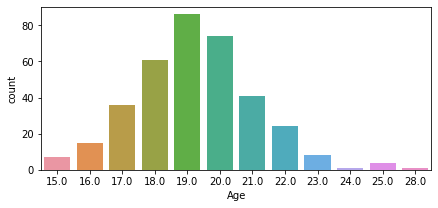

In [42]:
plt.figure(figsize=(7, 3))
sns.countplot(x="Age", data=km_1)

U ovom klasteru može se uočiti veća zastupljenost muškaraca u odnosu na žene, te ima smisla razmatrati *Gender* atribut. Starosna raspodela, i nivo obrazovanja ukazuju da veći deo ispitanika pripada mlađoj populaciji, između 18-20 godina, i pohađa osnovnu i srednju školu, mada se javlja i određeni (mali ali ipak ne beznačajan) broj studenata. Može se primetiti da u ovom klasteru *Movies* atribut ima najveću prosečnu vrednost, što ukazuje da ispitanici iz ovog klastera generalno više vole da gledaju filmove u odnosu na ispitanike ostalih klastera. Primećuje se da su prosečne ocene svih žanrova filmova značajno više u odnosu na prethodni klaster, što se može objasniti prethodno navedenom obzervacijom. *Western* filmovi su jedini koje dati ispitanici ne vole, sa relativno niskom prosečnom ocenom, mada se iz prethodno navedenih statistika celog skupa podataka vidi generalno niska ocena ovih filmova. *Horror* i *Romantic* filmovi uživaju prosečnu preferencu, što se može objasniti mlađom populacijom i većom zastupljenošću muškog pola. Ispitanici iz ovog klastera najviše uživaju u *Action* i *Comedy* filmovima, dok ostali žanrovi imaju relativno visoke ocene, oko 4.

**Klaster 2**

In [43]:
km_clusters_means.iloc[[2]]

,Movies,Horror,Thriller,Comedy,Romantic,Sci-fi,War,Fantasy/Fairy tales,Animated,Documentary,Western,Action,Age,Gender_male,Education_currently a primary school pupil,Education_doctorate degree,Education_masters degree,Education_primary school,Education_secondary school,House - block of flats_house/bungalow
2,4.66766,2.31437,2.76048,4.69162,4.19760,2.53892,2.28743,4.51497,4.49401,3.44012,1.62275,2.94910,19.69162,0.08683,0.00599,0.00000,0.02994,0.08982,0.67066,0.38623


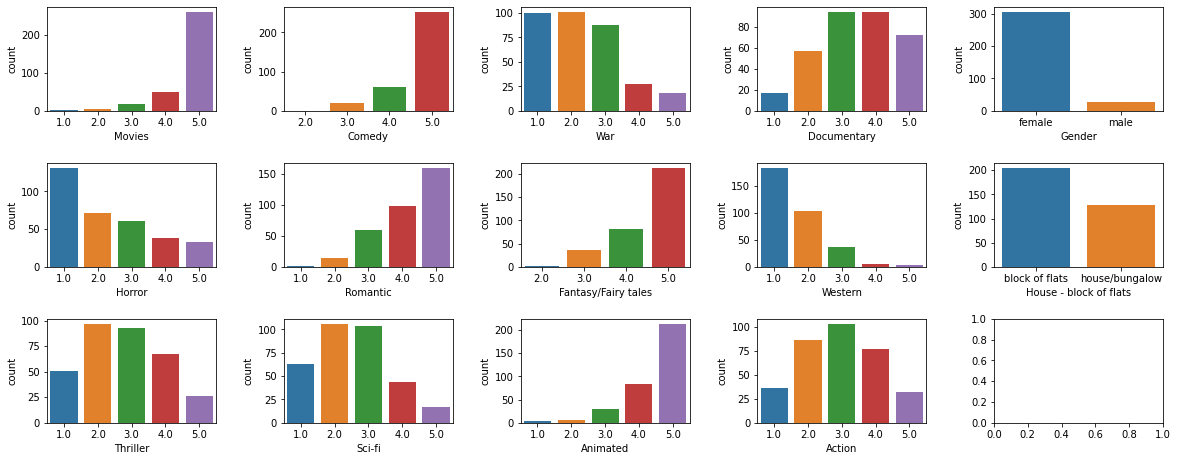

In [44]:
km_2 = km_clusters.get_group(2)
plot_countplots(data=km_2.drop(["Education", "Age"], axis=1),
                num_rows=3, num_cols=5)

<AxesSubplot:xlabel='Education', ylabel='count'>

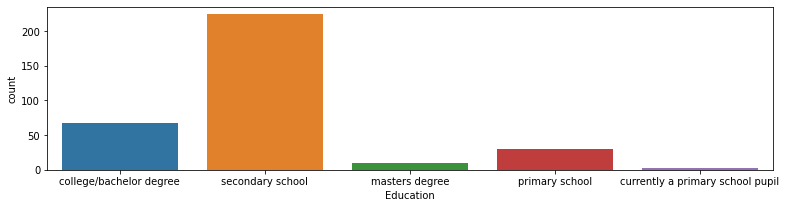

In [45]:
plt.figure(figsize=(13, 3))
sns.countplot(x="Education", data=km_2)

<AxesSubplot:xlabel='Age', ylabel='count'>

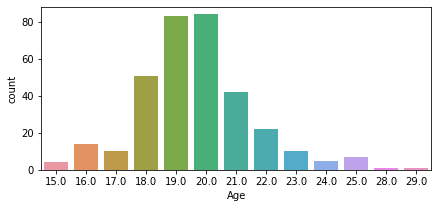

In [46]:
plt.figure(figsize=(7, 3))
sns.countplot(x="Age", data=km_2)

Poslednji klaster čini većinski ženska populacija, sa niskim procentom zastupljenosti muškaraca. Starosna i obrazovna struktura dosta podseća na prethodni klaster, odnosno većinu čini mlađa populacija zajedno sa manjim brojem studenata. Ispitanici ovog klastera takođe uživaju u gledanju filmova, što se može videti iz distribucije *Movies* atributa. Iako ispitanici generalno uživaju u gledanju filmova, može se videti jasna granica između prefererianih i nepreferiranih žanrova, što nije nužno bio slučaj kod prethodnih klastera. *Horror*, *Thriller*, *Sci-fi*, *War*, *Western* i *Action* filmovi imaju izuzetno negativnu distribuciju ocena, što se možda može povezati sa distribucijom pola ispitanika. *Documentary* filmovi uživaju "jaču" prosečnu preferencu (većina ispitanika dala je ocene 3 i 4). Ispitanici ovog klastera najviše preferiraju *Comedy*, *Romantic*, *Animated*, *Fantacy/Fairy tale* žanrove, što se može objasniti starosnom i polnom struktorom u klasteru.

#### *Hijerarhijska klasterizacija (Agglomerative Clustering)*
Prethodnom analizom utvrđeno je da će *Agglomerative* klasterizacija biti korišćen sa **inicijalnim** podacima i **3** klastera.

In [47]:
agl_num_clusters = 3
agl = AgglomerativeClustering(n_clusters=agl_num_clusters, compute_distances=True)
agl = agl.fit(data_movie_n)

# evaluate clusters
eval_scores(data_movie_n, agl.labels_, nn_metric='cosine')

Silhouette score: 0.17897833812232616
Calinski Harabasz score: 130.63826927259814


Slično, data je vizuelizacija klastera u 2D i 3D korišćenjem PCA. Klasteri nisu potpuno separatisani, odnosno postoji mala doza preklapanja.

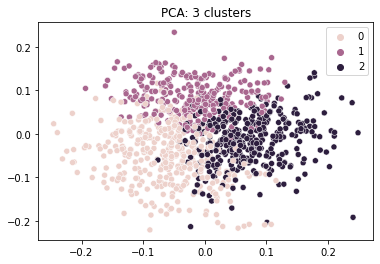

In [48]:
plot_clusters_pca_2d(3, data_movie_n, agl.labels_, num_clusters=agl_num_clusters)

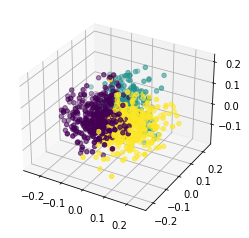

In [49]:
plot_clusters_pca_3d(3, data_movie_n, agl.labels_, num_clusters=agl_num_clusters)

Vizuelizacija klastera, u slučaju hijerarhijske klasterizacije, podrazumeva specifičan dijagram - *dendrogram*. Dobijeni dendrogram dat je u nastavku.
Dendrogram se može koristiti za određivanje optimanog broja klastera. Treba pronaći horizontalni pravougaonik sa najvećom visinom koji ne pokriva nijednu horizontalanu liniju na dijagramu. Ova metoda se koristi zato što visina ovakvog pravougaonika predstavlja maksimalno euklidsko rastojanje između optimalnog broja klastera. U ovom slučaju optimalni broj klastera je **3**.

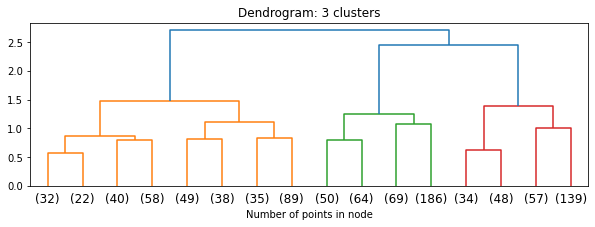

In [50]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    plt.figure(figsize=(10, 3))
    plt.xlabel("Number of points in node")
    plt.title("Dendrogram: 3 clusters")
    
    dendrogram(linkage_matrix, **kwargs)
    
    
plot_dendrogram(agl, truncate_mode='level', p=3)

Slično KMeans klasterizaciji, izvršena je vizuelizacija pojedinačnih klastera koriščenjem originalnih vrednosti atributa (pre normalizacije/skaliranja), kao i prikaz centara odgovarajućih klastera.

In [51]:
agl_clusters = data_movie.groupby(agl.labels_)
agl_clusters_means = data_movie_e.groupby(agl.labels_).mean()
agl_clusters_means

,Movies,Horror,Thriller,Comedy,Romantic,Sci-fi,War,Fantasy/Fairy tales,Animated,Documentary,Western,Action,Age,Gender_male,Education_currently a primary school pupil,Education_doctorate degree,Education_masters degree,Education_primary school,Education_secondary school,House - block of flats_house/bungalow
0,4.39945,2.76584,3.28099,4.29752,3.27273,2.60331,2.77961,3.05510,2.94215,3.38567,1.85675,3.24518,22.06061,0.40220,0.00551,0.01377,0.16529,0.03581,0.55923,0.39118
1,4.75180,2.35612,2.85612,4.76259,4.24101,2.60072,2.46403,4.65468,4.69424,3.67266,1.75899,3.12950,19.20504,0.07554,0.01079,0.00000,0.01439,0.12950,0.65827,0.41007
2,4.72629,3.15176,3.88347,4.49051,3.14092,4.00000,4.04607,3.75339,3.94038,3.88347,2.66667,4.13279,19.75068,0.66125,0.01355,0.00000,0.04607,0.08401,0.63957,0.42005


**Klaster 0**

Centar datog klastera prikazan je sledećom tabelom. Distribucija vrednosti atributa u okviru klastera data je na sledećim dijagramima, pri čemu se Age i Education fičeri izdvojeni zbog bolje preglednosti.

In [52]:
agl_clusters_means.iloc[[0]]

,Movies,Horror,Thriller,Comedy,Romantic,Sci-fi,War,Fantasy/Fairy tales,Animated,Documentary,Western,Action,Age,Gender_male,Education_currently a primary school pupil,Education_doctorate degree,Education_masters degree,Education_primary school,Education_secondary school,House - block of flats_house/bungalow
0,4.39945,2.76584,3.28099,4.29752,3.27273,2.60331,2.77961,3.05510,2.94215,3.38567,1.85675,3.24518,22.06061,0.40220,0.00551,0.01377,0.16529,0.03581,0.55923,0.39118


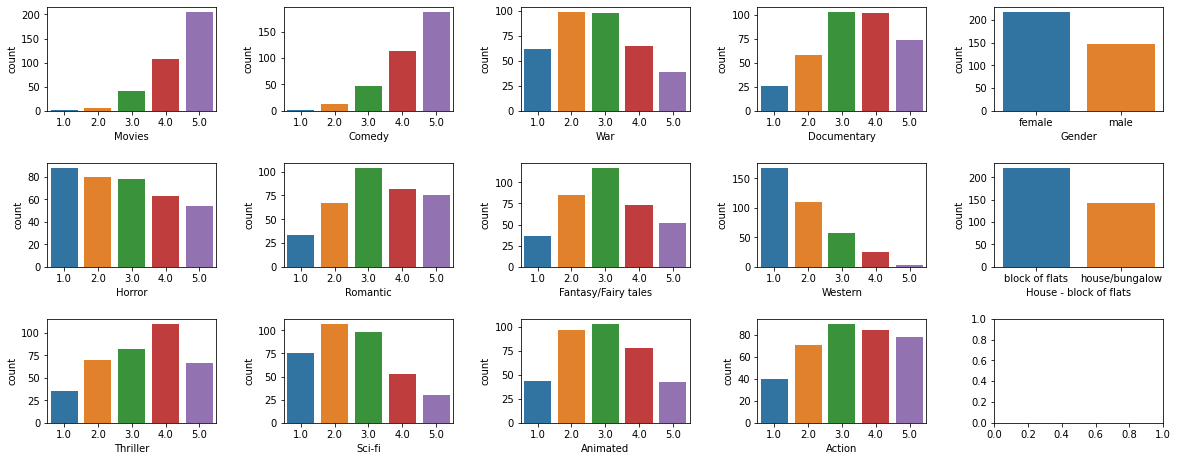

In [53]:
agl_0 = agl_clusters.get_group(0)
plot_countplots(data=agl_0.drop(["Education", "Age"], axis=1),
                num_rows=3, num_cols=5)

<AxesSubplot:xlabel='Education', ylabel='count'>

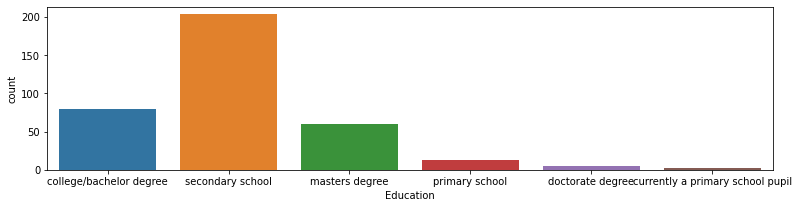

In [54]:
plt.figure(figsize=(13, 3))
sns.countplot(x="Education", data=agl_0)

<AxesSubplot:xlabel='Age', ylabel='count'>

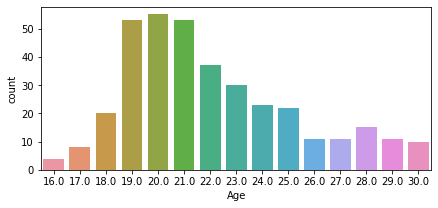

In [55]:
plt.figure(figsize=(7, 3))
sns.countplot(x="Age", data=agl_0)

U ovom klasteru su više zastupljene žene od muškaraca sa manje značajnom razlikom, uglavnom srednjoškolskog obrazovanja zbog generalno najveće zastupljenosti ovog tipa obrazovanja. Njihova starost se rangira uglavnom između 18-25 godina. Takođe ispitanici iz ovog klastera najmanje vole *Western* filmove sa ocenom ispod 2, a najviše preferiraju *Comedy* žanr . Ostali žanrovi se nalaze s ocenama u rangu 2.5-3.5. Možemo videti da postoji jasna razlika između žanra sa najmanjom, srednjom i najvišom ocenom ispitanika.

**Klaster 1**

In [56]:
agl_clusters_means.iloc[[1]]

,Movies,Horror,Thriller,Comedy,Romantic,Sci-fi,War,Fantasy/Fairy tales,Animated,Documentary,Western,Action,Age,Gender_male,Education_currently a primary school pupil,Education_doctorate degree,Education_masters degree,Education_primary school,Education_secondary school,House - block of flats_house/bungalow
1,4.75180,2.35612,2.85612,4.76259,4.24101,2.60072,2.46403,4.65468,4.69424,3.67266,1.75899,3.12950,19.20504,0.07554,0.01079,0.00000,0.01439,0.12950,0.65827,0.41007


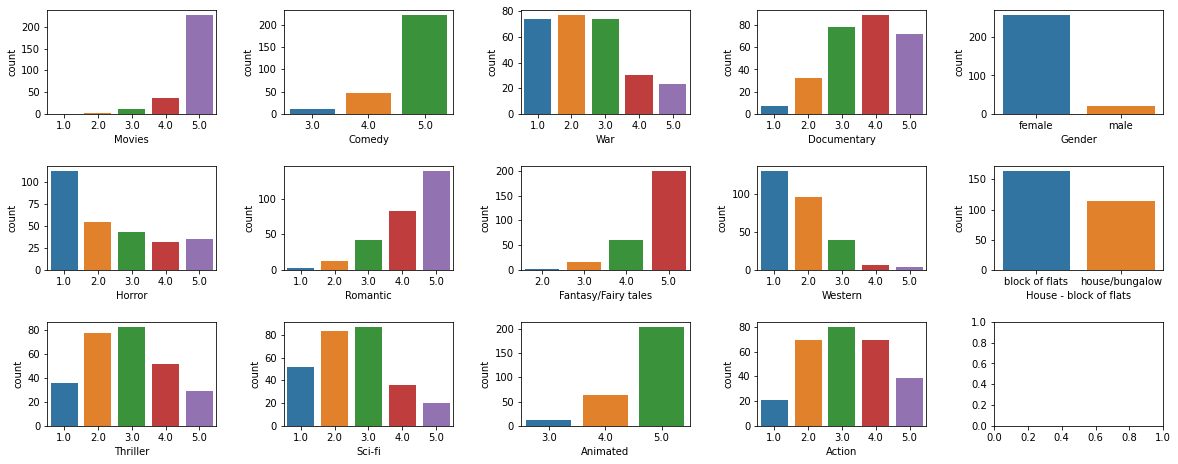

In [57]:
agl_1 = agl_clusters.get_group(1)
plot_countplots(data=agl_1.drop(["Education", "Age"], axis=1),
                num_rows=3, num_cols=5)

<AxesSubplot:xlabel='Education', ylabel='count'>

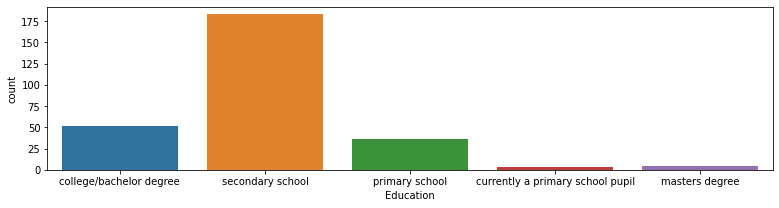

In [58]:
plt.figure(figsize=(13, 3))
sns.countplot(x="Education", data=agl_1)

<AxesSubplot:xlabel='Age', ylabel='count'>

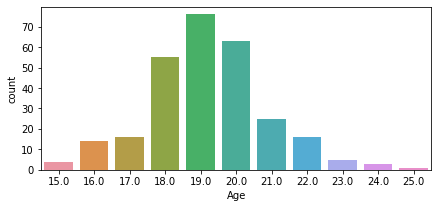

In [59]:
plt.figure(figsize=(7, 3))
sns.countplot(x="Age", data=agl_1)

Za razliku od prethodnog klastera ovaj klaster čine uglavnom žene, sa malim procentom muškaraca. Raspodela edukacije je slična sa prethodnim klasterom. Starosni rang ispitanika se kreće u opsegu 18-21. Možemo videti da su ispitanici iz ovog klastera mlađi od ispitanika svrstanih u prethodni klaster. Takođe, možemo primetiti da kao i u prethodnom klasteru ispitanici najmanje vole *Western* filmove, dok preferiraju *Comedy*, *Romantic*, *Fantasy/Fairy tales* i *Animated* filmove.

**Klaster 2**

In [60]:
agl_clusters_means.iloc[[2]]

,Movies,Horror,Thriller,Comedy,Romantic,Sci-fi,War,Fantasy/Fairy tales,Animated,Documentary,Western,Action,Age,Gender_male,Education_currently a primary school pupil,Education_doctorate degree,Education_masters degree,Education_primary school,Education_secondary school,House - block of flats_house/bungalow
2,4.72629,3.15176,3.88347,4.49051,3.14092,4.00000,4.04607,3.75339,3.94038,3.88347,2.66667,4.13279,19.75068,0.66125,0.01355,0.00000,0.04607,0.08401,0.63957,0.42005


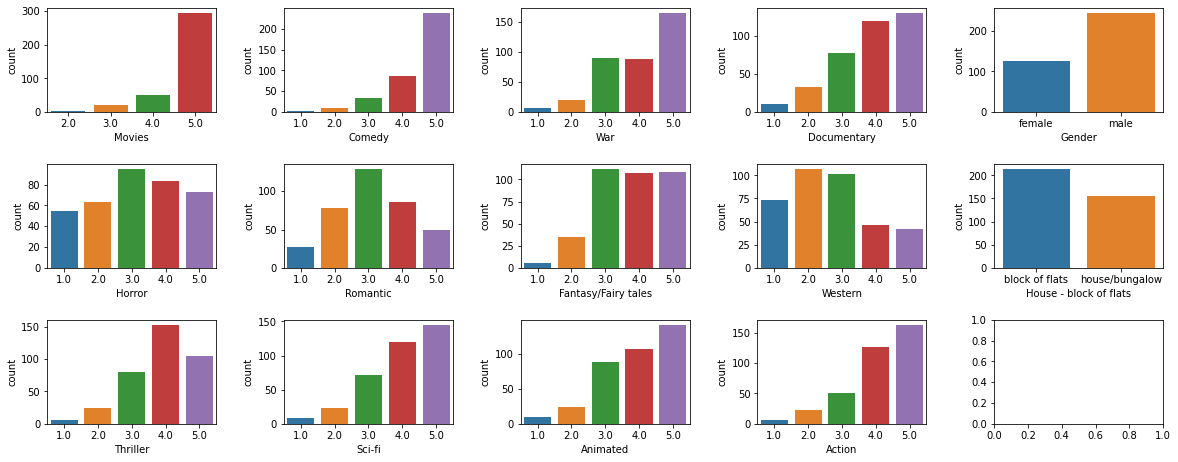

In [61]:
agl_2 = agl_clusters.get_group(2)
plot_countplots(data=agl_2.drop(["Education", "Age"], axis=1),
                num_rows=3, num_cols=5)

<AxesSubplot:xlabel='Education', ylabel='count'>

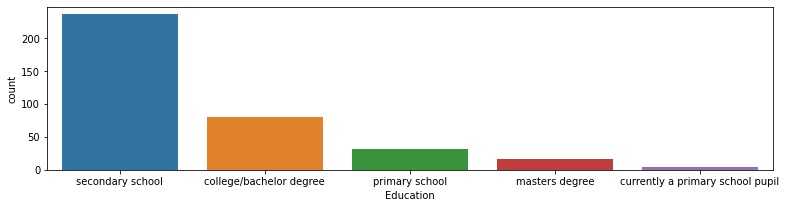

In [62]:
plt.figure(figsize=(13, 3))
sns.countplot(x="Education", data=agl_2)

<AxesSubplot:xlabel='Age', ylabel='count'>

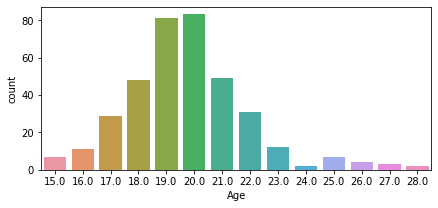

In [63]:
plt.figure(figsize=(7, 3))
sns.countplot(x="Age", data=agl_2)

Za raliku od prethodna dva klastera, većinu u ovom klasteru čini muška populacija u starosnom opsegu 17-22. Distribucija obrazovanja je slična kao u prethodna dva klastera. Ispitanici najviše preferiraju *Comedy*, dok najmanje *Western* filmove. Takođe možemo videti i da *War*, *Sci-fi* i *Action* filmovi imaju visoku ocenu.

### ***Zaključak***
U ovom notebook-u demonstrirano je korišćenje većeg broja tehnika klasterizacije ne bi li se klasterizovali mladi ljudi na osnovu njihovih ukusa u oblasti filma i otkrile interesantne korelacije u podacima. Kako se radilo sa skupom podataka koji sadrži veliki broj kolona iz različitih oblasti života bilo je izazovno odrediti podskup atributa koji će biti od značaja za ovakvu vrstu analize. Nakon inicijalne selekcije atributa pokušana je PCA tehnika redukcije dimenzionalnosti, ali se ona ispostavila kao nepovoljna za dati skup podataka. 
Klasterizacija je pokušana korišćenjem nekoliko tehnika, od kojih su se DBSCAN i MeanShift pokazale kao nepovoljne, dok su KMeans i Agglomerative Clustering dali relativno slične objektivne ocene kvaliteta dobijenih klastera, pri čemu se KMeans pokazao za nijansu bolje.
Analiza dobijenih klastera ukazala je na interesatnu podelu ispitanika, kao i na moguće zavisnosti između preferenci žanrova filmova i demografskih podataka. Može se takođe primetiti da obe napomenute tehnike kao rezultate daju sličnu raspodelu klastera. 